# preprocess.py

In [3]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os, re, json
import numpy as np
import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt

In [6]:
FILTERS = "([~.,!?\"':;)(])"
PAD = "<PAD>"  # 패딩 토큰
STD = "<SOS>"  # 시작 토큰
END = "<END>"  # 종료 토큰
UNK = "<UNK>"  # 사전에 없는 단어

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)  # "([~.,!?\"':;)(])" 해당 문자들 중에 하나

MAX_SEQUENCE = 25

In [7]:
# 데이터 불러오는 함수
def load_data(path):
    data_df = pd.read_csv(path, header=0)
    question, answer = list(data_df['Q']), list(data_df['A'])

    return question, answer

In [8]:
# 데이터 전처리한 후 단어 리스트로 만드는 함수
def data_tokenizer(data):
    words = []
    for sentence in data:
        # FILTERS = "([~.,!?\"':;)(])" 필터와 같은 값들을 정규화 표현식을 통해서 모두 "" 으로 변환
        sentence = re.sub(CHANGE_FILTER, "", sentence)
        for word in sentence.split():
            words.append(word)

    return [word for word in words if word]

In [9]:
# 형태소로 분리하는 함수
def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in tqdm(data):
        # 형태소로 분리한 다음 형태소별로 공백을 추가함
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data

In [10]:
# 단어 사전을 만드는 함수
def load_vocabulary(path, vocab_path, tokenize_as_morph=False):
    vocabulary_list = []
    # 사전을 구성한 후 파일로 저장 진행하고 파일의 존재 유무 확인
    # 사전 파일이 있다면 불러와서 사용하고, 없으면 만들기
    if not os.path.exists(vocab_path):
        if (os.path.exists(path)):
            data_df = pd.read_csv(path, encoding='utf-8')
            question, answer = list(data_df['Q']), list(data_df['A'])
            if tokenize_as_morph:  # 형태소에 따른 토크나이저 처리
                question = prepro_like_morphlized(question)
                answer = prepro_like_morphlized(answer)
            
            # 질문과 답변을 extend을 통해서 구조가 없는 배열로 생성
            data = []
            data.extend(question)
            data.extend(answer)
            words = data_tokenizer(data) # 토크나이저 진행
            words = list(set(words)) # 중복 제거를 위해 set 사용하고 리스트로 만들기
            words[:0] = MARKER # 리스트의 첫번째부터 순서대로 넣기 위해 인덱스 0부터 사전에 MARKER 추가
        
        # 리스트로 만든 사전을 파일로 만들기
        with open(vocab_path, 'w', encoding='utf-8') as vocabulary_file:
            for word in words:
                vocabulary_file.write(word + '\n')

    # 사전 파일이 존재하면 배열에 넣어주기
    with open(vocab_path, 'r', encoding='utf-8') as vocabulary_file:
        for line in vocabulary_file:
            vocabulary_list.append(line.strip())

    # 두가지 형태의 키와 값이 있는 딕셔너리 리턴
    # (예) 단어: 인덱스 , 인덱스: 단어)
    char2idx, idx2char = make_vocabulary(vocabulary_list)

    return char2idx, idx2char, len(char2idx)

In [11]:
def make_vocabulary(vocabulary_list):
    char2idx = {char: idx for idx, char in enumerate(vocabulary_list)}  # 단어: 인덱스
    idx2char = {idx: char for idx, char in enumerate(vocabulary_list)}  # 인덱스: 단어
    
    return char2idx, idx2char

In [12]:
# 불러온 데이터 인코더에 적용될 입력값 만드는 전처리 함수
def enc_processing(value, dictionary, tokenize_as_morph=False):
    sequences_input_index = []  # 인덱스 값 배열
    sequences_length = []  # 인코딩 되는 문장의 길이 배열
    
    if tokenize_as_morph:  # 형태소 토크나이징 사용 유무
        value = prepro_like_morphlized(value)

    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence) # FILTERS = "([~.,!?\"':;)(])"를 ""로 변환
        sequence_index = [] # 하나의 문장을 인코딩할 때 가지고 있기 위한 배열

        for word in sequence.split():
            if dictionary.get(word) is not None:  # 잘려진 단어들이 딕셔너리에 존재하면 그 값을 sequence_index에 추가
                sequence_index.extend([dictionary[word]])
            else:  # 잘려진 단어가 딕셔너리에 존재하지 않기 때문에 UNK(2) 추가
                sequence_index.extend([dictionary[UNK]])
        
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰 삭제
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이 넣어줌
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가 작다면 빈 부분에 PAD(0) 추가
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을 sequences_input_index에 넣어줌
        sequences_input_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경(텐서플로우 dataset에 넣어 주기 위한 사전 작업)
    # 넘파이 배열에 인덱스화된 배열과 그 길이 리턴
    return np.asarray(sequences_input_index), sequences_length

In [13]:
# 디코더의 입력으로 사용될 입력값을 만드는 전처리 함수
def dec_output_processing(value, dictionary, tokenize_as_morph=False):
    sequences_output_index = [] # 인덱스 값 배열
    sequences_length = [] # 디코딩 입력되는 문장의 길이 배열
    
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
    
    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)   # FILTERS = "([~.,!?\"':;)(])"를 ""로 변환
        sequence_index = [] # 하나의 문장을 디코딩 할 때 가지고 있기 위한 배열
        # 디코딩 입력의 처음에 START가 와야 함
        # 공백에 따라 단어를 가져와서 딕셔너리의 값인 인덱스를 넣어줌
        sequence_index = [dictionary[STD]] + [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]
       
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰 삭제
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가 작다면 빈 부분에 PAD(0) 추가
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을 sequences_input_index에 넣어줌
        sequences_output_index.append(sequence_index)

    # 인덱스화된 일반 배열을 넘파이 배열로 변경(텐서플로우 dataset에 넣어 주기 위한 사전 작업)
    # 넘파이 배열에 인덱스화된 배열과 그 길이 리턴
    return np.asarray(sequences_output_index), sequences_length

In [14]:
# 디코더의 결과로 학습을 위해 필요한 라벨인 타깃값을 만드는 전처리 함수
def dec_target_processing(value, dictionary, tokenize_as_morph=False):
    sequences_target_index = [] # 인덱스 값 배열
    
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
   
    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)  # FILTERS = "([~.,!?\"':;)(])"를 ""로 변환
        # 공백에 따라 단어를 가져와서 딕셔너리의 값인 인덱스를 넣어줌
        # 디코딩 출력의 마지막에 END 넣어주기
        sequence_index = [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]
        
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰 삭제 후 END 토큰 넣어주기
        if len(sequence_index) >= MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE - 1] + [dictionary[END]]
        else:
            sequence_index += [dictionary[END]]
        # max_sequence_length보다 문장 길이가 작다면 빈 부분에 PAD(0) 추가
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을 sequences_input_index에 넣어줌
        sequences_target_index.append(sequence_index)

    # 인덱스화된 일반 배열을 넘파이 배열로 변경(텐서플로우 dataset에 넣어 주기 위한 사전 작업)
    # 넘파이 배열에 인덱스화된 배열과 그 길이 리턴
    return np.asarray(sequences_target_index)

# preprocess.ipynb

In [15]:
# from preprocess import *

In [16]:
# 학습할 데이터 경로와 저장할 단어사전 경로 선언
############## 폴더명 바꾸기 ###################
PATH = '/content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_in/sample.csv'
VOCAB_PATH = '/content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_in/vocabulary.txt'

# 학습할 데이터 불러오기
inputs, outputs = load_data(PATH)
# 단어 사전 만들기, tokenize_as_morph 파라미터를 통해 형태소 단위로 토크나이즈함
char2idx, idx2char, vocab_size = load_vocabulary(PATH, VOCAB_PATH, tokenize_as_morph=False)

In [17]:
index_inputs, input_seq_len = enc_processing(inputs, char2idx, tokenize_as_morph=True)
index_outputs, output_seq_len = dec_output_processing(outputs, char2idx, tokenize_as_morph=True)
index_targets = dec_target_processing(outputs, char2idx, tokenize_as_morph=True)

100%|██████████| 51628/51628 [07:36<00:00, 113.03it/s]


In [18]:
# 단어사전과 특별한 토큰들을 각각 정의해서 딕셔너리 객체에 젖장
data_configs = {}
data_configs['char2idx'] = char2idx
data_configs['idx2char'] = idx2char
data_configs['vocab_size'] = vocab_size
data_configs['pad_symbol'] = PAD
data_configs['std_symbol'] = STD
data_configs['end_symbol'] = END
data_configs['unk_symbol'] = UNK

In [19]:
DATA_IN_PATH = '/content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_in/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

np.save(open(DATA_IN_PATH + TRAIN_INPUTS, 'wb'), index_inputs)
np.save(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'wb'), index_outputs)
np.save(open(DATA_IN_PATH + TRAIN_TARGETS , 'wb'), index_targets)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'))

# transformer.ipynb
---
- 트랜스포머 모델 : 전체 문장이 한번에 행렬 형태로 입력되는 구조

In [20]:
# from preprocess import *

In [21]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Okt
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

## 학습 시각화를 위한 시각화 함수

In [22]:
# 에폭당 정확도와 손실값을 시각화하는 함수
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string], '')
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

## 학습데이터 경로 정의

In [23]:
############## 폴더명 바꾸기 ###################
DATA_IN_PATH = '/content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_in/'
DATA_OUT_PATH = '/content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

In [24]:
# 랜덤 시드값
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [25]:
# 미리 전처리된 학습에 필요한 데이터와 설정값 불러오기
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [26]:
# 함수를 통과한 값들이 예상크기와 같은지 확인
print(len(index_inputs)), print(len(index_outputs)), print(len(index_targets))

51628
51628
51628


(None, None, None)

## 모델 하이퍼파라미터 정의

In [27]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCHS = 30
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1
        }

## 모델 선언 및 컴파일

### 패딩 및 포워드 마스킹

In [28]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [29]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [30]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [31]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

### 포지셔널 인코딩

In [32]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angle_rates

In [33]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


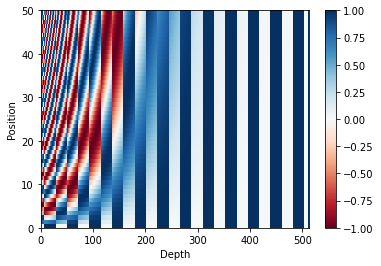

In [34]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 어텐션

In [35]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

### 멀티헤드 어텐션

In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

### 포인트 와이즈 피드포워드 네트워크



In [37]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(kargs['dff'], activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(kargs['d_model'])  # (batch_size, seq_len, d_model)
    ])

## 인코더 레이어

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, **kargs):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(**kargs)
    self.ffn = point_wise_feed_forward_network(**kargs)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
    self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

  def call(self, x, mask):
    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output)
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

## 디코더 레이어

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
    
    
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

## 인코더

In [40]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(**kargs) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

## 디코더

In [41]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 트랜스포머 모델

In [42]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, _ = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output
    
    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)        
        enc_output = self.encoder(inp, enc_padding_mask)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
            
        return predict_tokens

## 모델 로스 정의

In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [44]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

## callback 선언

In [45]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_out/transformer -- Folder create complete 



## 모델 학습

In [46]:
history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=BATCH_SIZE, epochs=10,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
23233/23233 [==============================] - ETA: 0s - loss: 1.8475 - accuracy: 0.7095
Epoch 1: val_accuracy improved from -inf to 0.72360, saving model to /content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_out/transformer/weights.h5
23233/23233 [==============================] - 2038s 87ms/step - loss: 1.8475 - accuracy: 0.7095 - val_loss: 1.5110 - val_accuracy: 0.7236
Epoch 2/10
23233/23233 [==============================] - ETA: 0s - loss: 1.5805 - accuracy: 0.7287
Epoch 2: val_accuracy improved from 0.72360 to 0.73245, saving model to /content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_out/transformer/weights.h5
23233/23233 [==============================] - 2021s 87ms/step - loss: 1.5805 - accuracy: 0.7287 - val_loss: 1.4094 - val_accuracy: 0.7324
Epoch 3/10
23233/23233 [==============================] - ETA: 0s - loss: 1.4826 - accuracy: 0.7354
Epoch 3: val_accuracy improved from 0.73245 to 0.73777, saving model to /content/drive/My

## 결과 플롯

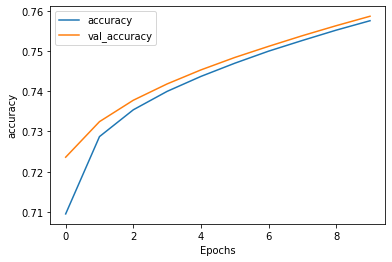

In [67]:
plot_graphs(history, 'accuracy')

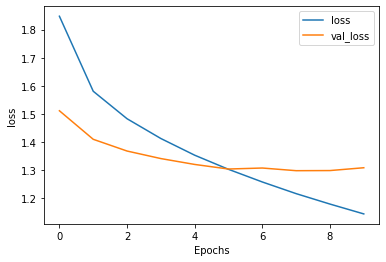

In [68]:
plot_graphs(history, 'loss')

## 베스트 모델 불러오기

In [49]:
############## 폴더명 바꾸기 ###################
DATA_OUT_PATH = '/content/drive/MyDrive/Colab Notebooks/자연어 음성 프로젝트/data_out/'
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

## 모델 결과 출력하기

In [ ]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

In [60]:
text = "3박4일 정도 놀러가고 싶다"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

어떤 일 때문 <UNK> 그러시나요


In [59]:
text = "나 취업했어 기분이 좋아"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

좋은 일이 있으셨군요


In [61]:
text = "궁금해"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

무슨 일로 그렇게 <UNK> 적 인 생각 을 하시나요


In [62]:
text = "무서워"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

아이 <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


In [63]:
text = "가난한 자의 설움"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

건강 이 많이 안좋으신 가요


In [64]:
text = "남자친구"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

남자친구 와 싸워서 마음 이 좋지 않으시군요


In [65]:
text = "여자친구"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

여자친구 와 싸워서 마음 이 <UNK>


In [66]:
text = "개학하니까 좋다"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

좋은 일이 있으셨군요 어떤 좋은 일이 있었나요
